In [1]:
%reload_ext autoreload
%autoreload 2
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pylab as plt
import scipy
from glob import glob
import matplotlib.pylab as plt


In [2]:
fn = glob(r'../data/openfield/*.pkl')
df = pd.read_pickle(fn[1])
df = df.sort_values('grid_score',ascending=False)

df.grid_score

281    0.867916
285   -0.149390
282   -0.227969
283   -0.466765
280         NaN
284         NaN
Name: grid_score, dtype: float64

In [11]:
df.session_id

281    M4_D26_2021-09-15_12-07-40
285    M4_D26_2021-09-15_12-07-40
282    M4_D26_2021-09-15_12-07-40
283    M4_D26_2021-09-15_12-07-40
280    M4_D26_2021-09-15_12-07-40
284    M4_D26_2021-09-15_12-07-40
Name: session_id, dtype: object

In [3]:
max_firing_time = max(df.firing_times.apply(max))*1000/30000
time_bin = np.arange(0, max_firing_time+10, 10) # 10ms

In [4]:
# Merge all the firing rate together
all_firing_time = []
all_pos_x = []
all_pos_y = []

for _, row in df.iterrows():
    all_firing_time.append(row.firing_times*1000/30000)
    all_pos_x.append(row.position_x)
    all_pos_y.append(row.position_y)
    
all_firing_time = np.concatenate(all_firing_time)
idx = np.argsort(all_firing_time)

all_firing_time = all_firing_time[idx]
all_pos_x = np.concatenate(all_pos_x)
all_pos_y = np.concatenate(all_pos_y)

all_pos_x = all_pos_x[idx]
all_pos_y = all_pos_y[idx]

In [5]:
#export the neuron firing data
position_x = row.position_x
position_y = row.position_y

# bin all cell
binned_firing = []
for _, row in df.iterrows():
    count, bin_center = np.histogram(row.firing_times*1000/30000, time_bin)
    binned_firing.append(count)
    
binned_firing = np.stack(binned_firing)
print(binned_firing.shape)

# use the firing_time to resample the position
f = scipy.interpolate.interp1d(all_firing_time, all_pos_x, bounds_error=False, fill_value = position_x[0])
x_interp = f(bin_center[:-1])

f = scipy.interpolate.interp1d(all_firing_time, all_pos_y, bounds_error=False, fill_value = position_y[0])
y_interp = f(bin_center[:-1])

# plt.plot(x_interp)
# plt.plot(y_interp)

assert len(x_interp) == len(y_interp) == len(count)

(6, 222146)


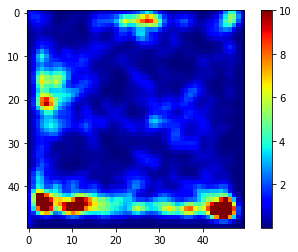

In [6]:
image,_,_ = np.histogram2d(x_interp, y_interp, weights=binned_firing[0,:], bins=50);
smooth_image = scipy.ndimage.gaussian_filter(image, sigma=1)
plt.imshow(smooth_image,  cmap='jet',vmax=10)
plt.colorbar()


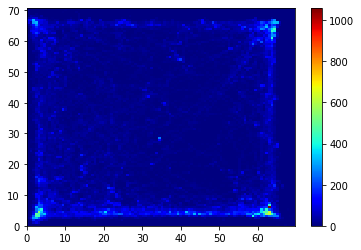

In [7]:
_,_,_,image = plt.hist2d(x_interp, y_interp, bins=100, cmap='jet');
plt.colorbar()

# Export data

In [71]:
data = np.vstack([x_interp, y_interp, binned_firing]).T
np.save('../data/openfield_cells.npy',data)